Simulated Patient 

In [84]:
import pandas as pd
import numpy as np
import os

from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier

In [85]:
from environment.fogg_behavioural_model import Patient

In [87]:
UpdatedEveryDayHours = 24
WeekHours = 7 * UpdatedEveryDayHours
ThreeWeeksHours = WeekHours * 3
EightWeeksHours = WeekHours * 8
FiveWeeksHours = WeekHours * 5

Condition = 'stable'
Habituation = False
#very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift
TimePreferenceUpdateStep = 9999999999999999
# 500 runs in the paper
RunCount = 50

In [89]:
ResultsDirectory = 'results'
if not os.path.exists(ResultsDirectory):
  os.makedirs(ResultsDirectory)

# Plots

In [90]:
from typing import NamedTuple

class ExperimentResult(NamedTuple):
  sleep_hours: list[float]
  positive_mood_hours: list[float]
  response_ratios: list[float]
  notifications: list[float]


In [91]:
def plot_experiment_result_hours(result: ExperimentResult):
  (sleeps_hours, positive_moods_hours, _, _) = result

  plt.figure(figsize=(8, 5))
  plt.plot(np.nanmean(sleeps_hours, axis=0), label='Hours slept', color='r')
  plt.plot(np.mean(positive_moods_hours, axis=0), label='Hours in positive mood')
  plt.ylabel('Hours ')
  plt.xlabel('Intervention Days')
  plt.legend()
  plt.show()

def plot_experiment_result_ratios(result: ExperimentResult):
  (_, _, ratios, notifications) = result

  _, (ratios_axis, notifications_axis) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
  ratios_axis.plot(np.nanmean(ratios, axis=0), label='response ratio', color='r')
  notifications_axis.plot(np.nanmean(notifications, axis=0), label='num of notifications')
  notifications_axis.set_xlabel('Intervention days')
  notifications_axis.set_ylabel('No. of notifications')
  ratios_axis.set_ylabel('Response ratio')
  plt.show()


# No intervention

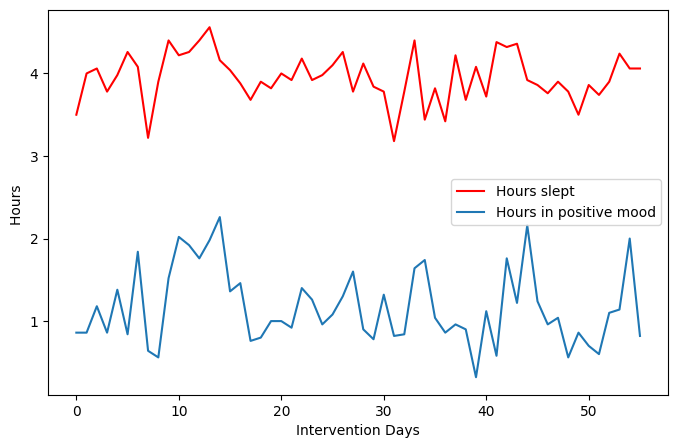

In [92]:

def run_no_intervention_experiment(epoch_count: int) -> ExperimentResult:
  sleep_hours = []
  positive_hours = []
  ratios = []
  notifications = []

  for _ in range(epoch_count):
    environment = Patient(
      behaviour_threshold=20,
      habituation=Habituation,
      time_preference_update_step=TimePreferenceUpdateStep
    )

    for _ in range(EightWeeksHours):
      observation, reward, done, _, info = environment.step(0)

    sleep_hours.append(environment.h_slept)
    positive_hours.append(environment.h_positive)
    ratios.append(environment.rr)
    notifications.append(environment.num_notified)

  return ExperimentResult(sleep_hours, positive_hours, ratios, notifications)

result = run_no_intervention_experiment(RunCount)
plot_experiment_result_hours(result)


# Intervention

In [93]:
def save_epoch_to_csv(environment: Patient, condition: str, name: str, epoch: int):
  df = pd.DataFrame()
  df['response_ratio'] = environment.rr
  df['activity performed'] = environment.num_performed
  df['notifications'] = environment.num_notified
  df['sleep'] = environment.h_slept
  df['positive'] = environment.h_positive
  df['non_stationary'] = environment.h_nonstationary
  df.to_csv(f"{ResultsDirectory}/patient1_{condition}_{name}_run{epoch}.csv")

def run_intervention_experiment(method, epoch_count, name, condition):
  ratios = []
  notifications = []

  sleep_hours = []
  positive_mood_hours = []
  times_performed = 0

  for epoch in range(epoch_count):
    environment = method(
      Patient(
        behaviour_threshold=20,
        habituation=Habituation,
        time_preference_update_step=TimePreferenceUpdateStep
      )
    )

    if any(environment.num_performed): times_performed += 1

    save_epoch_to_csv(environment, condition, name, epoch)

    ratios.append(environment.rr)
    notifications.append(environment.num_notified)
    sleep_hours.append(environment.h_slept)
    positive_mood_hours.append(environment.h_positive)

  print("These figures include runs in which no prompt resulted in the activity being performed.")
  print(f"{times_performed} out of {epoch_count} resulted in activity being performed.")

  return ExperimentResult(sleep_hours, positive_mood_hours, ratios, notifications)


## Heuristic

Notify every hour except in night and when the patient is alseep

In [94]:
def always_notify(environment: Patient, intervention_length: int = EightWeeksHours) -> Patient:
  action = 0

  for _ in range(intervention_length):
    observation, _, _, _, _ = environment.step(action)
    # 9-th is the time of the day
    # 3 is the night
    if observation[9] == 3 or observation[3] == 1:
      action = 0
    else:
      action = 1

  return environment

These figures include runs in which no prompt resulted in the activity being performed.
32 out of 50 resulted in activity being performed.


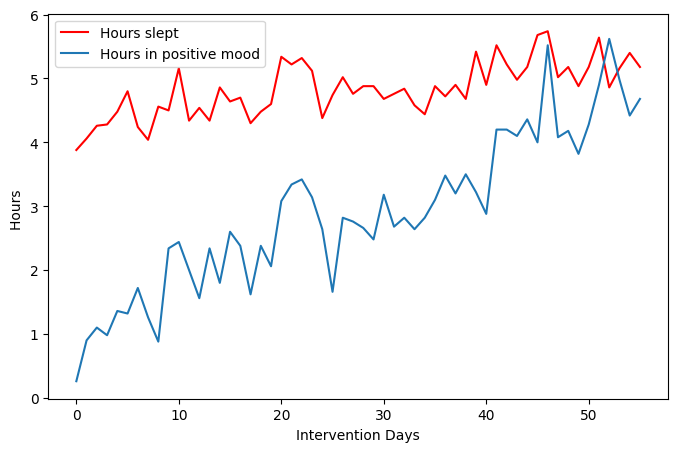

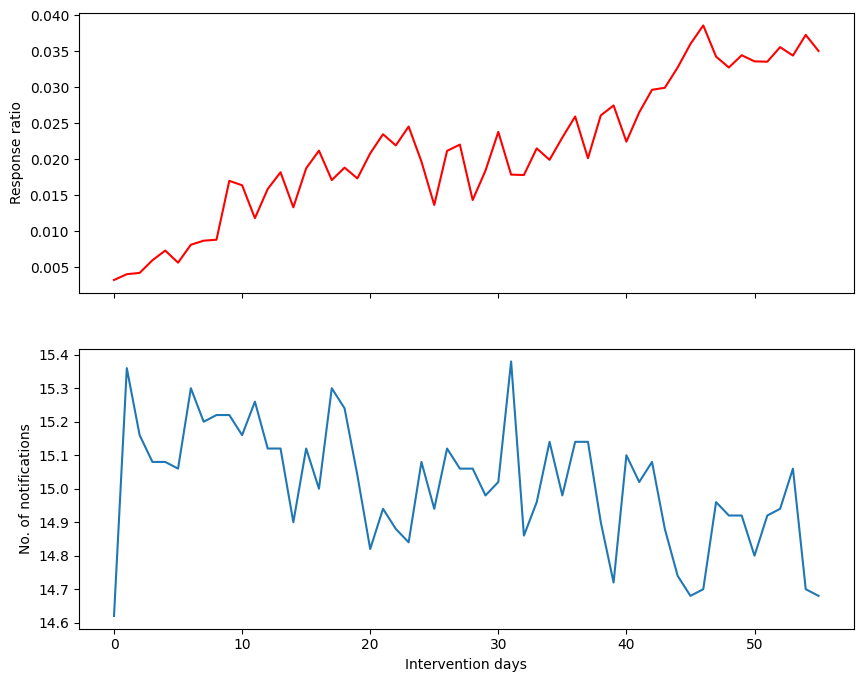

In [95]:
result = run_intervention_experiment(always_notify, RunCount, 'h', Condition)
plot_experiment_result_hours(result)
plot_experiment_result_ratios(result)


## Random 
Randomly sample during the day skip the nights

In [96]:
def random_notification(environment: Patient, intervention_length: int = EightWeeksHours) -> Patient:
  action = 0
  for i in range(intervention_length):

    observation, _, _, _, _ = environment.step(action)
    # 9-th is the time of the day
    if observation[9] == 3:
      action = 0
    else:
      action = environment.action_space.sample()

  return environment

In [97]:
class ReadResult(NamedTuple):
  ratios: list[float]
  notifications: list[float]

def read_ratios_and_notifications(name: str, epoch_count: int, condition: str) -> ReadResult:
  ratios = []
  notifications = []

  no_activity_count = 0
  for epoch in range(epoch_count):
    frame = pd.read_csv(f"{ResultsDirectory}/patient1_{condition}_{name}_run{epoch}.csv")
    has_performed_activity = any(frame['activity performed'].values)

    if has_performed_activity:
      ratios.append(frame.response_ratio)
      notifications.append(frame.notifications)
    else:
      no_activity_count += 1

  print(f" {no_activity_count} out of {epoch_count} runs had no activity performed throughout the full intervention.")
  return ReadResult(ratios, notifications)

## Supervised Learning

### Static model

In [98]:
def supervised_after_three_weeks(environment: Patient) -> Patient:
  environment = always_notify(environment, intervention_length=ThreeWeeksHours)
  classifier = RandomForestClassifier(class_weight='balanced')
  classifier.fit(environment.observation_list, environment.activity_performed)
  
  remaining_time = EightWeeksHours - ThreeWeeksHours
  observation = environment._get_current_state()

  for _ in range(remaining_time):
    # applying supervised model
    action = classifier.predict(np.array([observation]))[0]
    observation, _, _, _, _ = environment.step(action)

  return environment

### Adaptive model 

In [99]:
def supervised_adaptive_after_three_weeks(environment: Patient) -> Patient:
  environment = always_notify(environment, intervention_length=ThreeWeeksHours)
  classifier = RandomForestClassifier(class_weight='balanced')
  classifier.fit(environment.observation_list, environment.activity_performed)
  
  remaining_time = EightWeeksHours - ThreeWeeksHours
  observation = environment._get_current_state()
  samples = len(environment.observation_list)

  for _ in range(remaining_time):
    # applying supervised model
    action = classifier.predict(np.array([observation]))[0]
    observation, _, _, _, _ = environment.step(action)

    if len(environment.observation_list) <= samples: continue
    # retrain when new samples are provided
    classifier = RandomForestClassifier(class_weight='balanced')
    classifier.fit(environment.observation_list, environment.activity_performed)
    samples = len(environment.observation_list)

  return environment

## Deep Q Network

In [100]:
def dqn(environment: Patient) -> Patient:
  model = DQN("MlpPolicy", environment, verbose=0, learning_starts=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

## Proximal Policy Optimisation

In [101]:
def ppo(environment: Patient) -> Patient:
  model = PPO("MlpPolicy", environment, verbose=0, n_steps=UpdatedEveryDayHours, batch_size=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

## Advantage Actor Critic

In [102]:
def a2c(environment: Patient) -> Patient:
  model = A2C("MlpPolicy", environment, verbose=0, n_steps=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

## Comparison between prompt learning stategies

In [103]:
%time _ = run_intervention_experiment(always_notify, RunCount, 'h', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
37 out of 50 resulted in activity being performed.
CPU times: total: 1.45 s
Wall time: 1.49 s


In [104]:
%time _ = run_intervention_experiment(random_notification, RunCount, 'random', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
38 out of 50 resulted in activity being performed.
CPU times: total: 1.48 s
Wall time: 1.58 s


In [105]:
%time _ = run_intervention_experiment(supervised_adaptive_after_three_weeks, RunCount, 'static_sup3', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
28 out of 50 resulted in activity being performed.
CPU times: total: 2min 6s
Wall time: 2min 19s


In [106]:
%time _ = run_intervention_experiment(supervised_adaptive_after_three_weeks, RunCount, 'adaptive_sup3', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
26 out of 50 resulted in activity being performed.
CPU times: total: 2min 1s
Wall time: 2min 5s


In [107]:
%time _ = run_intervention_experiment(dqn, RunCount, 'dqn', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
35 out of 50 resulted in activity being performed.
CPU times: total: 20min 1s
Wall time: 1min 53s


In [108]:
%time _ = run_intervention_experiment(ppo, RunCount, 'ppo', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
30 out of 50 resulted in activity being performed.
CPU times: total: 39min 39s
Wall time: 3min 29s


In [109]:
%time _ = run_intervention_experiment(a2c, RunCount, 'a2c', Condition)

These figures include runs in which no prompt resulted in the activity being performed.
39 out of 50 resulted in activity being performed.
CPU times: total: 15min 42s
Wall time: 1min 19s


In [110]:
always_notify_result = read_ratios_and_notifications('h', RunCount, Condition)
random_result = read_ratios_and_notifications('random', RunCount, Condition)
static_sup3_result = read_ratios_and_notifications('static_sup3', RunCount, Condition)
adaptive_sup3_result = read_ratios_and_notifications('adaptive_sup3', RunCount, Condition)
dqn_result = read_ratios_and_notifications('dqn', RunCount, Condition)
ppo_result = read_ratios_and_notifications('ppo', RunCount, Condition)
a2c_result = read_ratios_and_notifications('a2c', RunCount, Condition)

 13 out of 50 runs had no activity performed throughout the full intervention.
 12 out of 50 runs had no activity performed throughout the full intervention.
 22 out of 50 runs had no activity performed throughout the full intervention.
 24 out of 50 runs had no activity performed throughout the full intervention.
 15 out of 50 runs had no activity performed throughout the full intervention.
 20 out of 50 runs had no activity performed throughout the full intervention.
 11 out of 50 runs had no activity performed throughout the full intervention.


C:\Users\dan\AppData\Local\Temp\ipykernel_1196\2326283281.py:5: RuntimeWarning: Mean of empty slice
  ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)


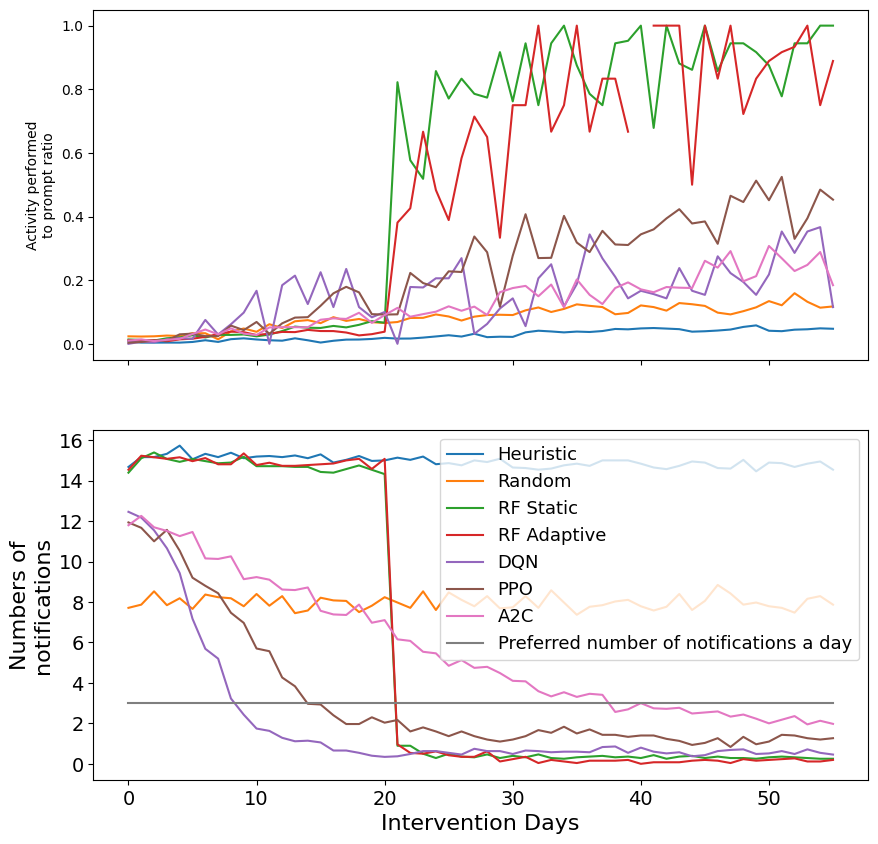

In [122]:
def plot_experiment_results_ratio(not_random_result: ReadResult, result_map: dict[str, ReadResult]):
  _, (ratios_axis, notifications_axis) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 10))

  for label, (ratios, notifications) in result_map.items():
    ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
    notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)

  notifications_axis.plot(np.ones(len(np.mean(not_random_result.notifications, axis=0))) + 2,
                          label='Preferred number of notifications a day')
  notifications_axis.set_xlabel('Intervention Days', fontsize=16)
  notifications_axis.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
  ratios_axis.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)))
  notifications_axis.legend(fontsize=13)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()

plot_experiment_results_ratio(random_result, {
  'Heuristic': always_notify_result,
  'Random': random_result,
  'RF Static': static_sup3_result,
  'RF Adaptive': adaptive_sup3_result,
  'DQN': dqn_result,
  'PPO': ppo_result,
  'A2C': a2c_result
})